In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### load two pictures

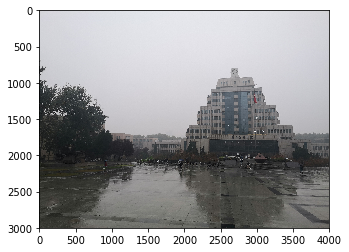

(<matplotlib.image.AxesImage at 0x11d3dfe1f28>, None)

In [2]:
img1 = cv2.imread('library11.jpg')
img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1rgb), plt.show()

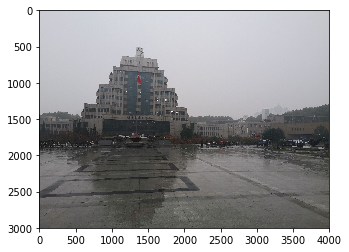

(<matplotlib.image.AxesImage at 0x11d447b3b70>, None)

In [3]:
img2 = cv2.imread('library12.jpg')
img2rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2rgb), plt.show()

### surf and knn

In [4]:
surf = cv2.xfeatures2d_SURF().create(2000)    # threshold of Hessian matrix
# find keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)

# FLANN-kNN parameters
flann_index = 1    # KD-tree index
index_params = dict(algorithm=flann_index, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

### find and draw good matches

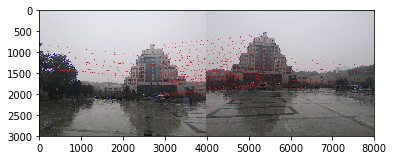

(<matplotlib.image.AxesImage at 0x11d4beb8f28>, None)

In [5]:
matcheslist = [[0, 0] for i in range(len(matches))]
good, pts1, pts2 = [], [], []
# search
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        matcheslist[i] = [1, 0]
# draw
draw_params = dict(matchColor=(0, 0, 255),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matcheslist,
                   flags=0)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2,
                         matches, None, **draw_params)
img3rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img3rgb), plt.show()

### perspective transform

In [6]:
min_matches = 10
if len(good) < min_matches:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None
else:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # apply perspective transform to img2
    warpImg = cv2.warpPerspective(img2, np.array(M), (img2.shape[1]*2, img2.shape[0]),
                                  flags=cv2.WARP_INVERSE_MAP)
    # padding img1 with 0
    img1 = cv2.copyMakeBorder(img1, 0, 0, 0, img2.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))

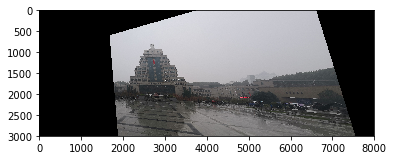

(<matplotlib.image.AxesImage at 0x11d3bb1e630>, None)

In [7]:
    warpImgrgb = cv2.cvtColor(warpImg, cv2.COLOR_BGR2RGB)
    plt.imshow(warpImgrgb), plt.show()

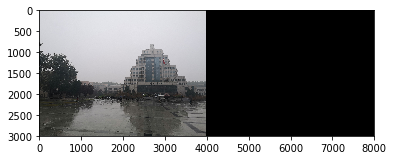

(<matplotlib.image.AxesImage at 0x11d3bb840b8>, None)

In [8]:
    img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    plt.imshow(img1rgb), plt.show()

### stitch two pictures

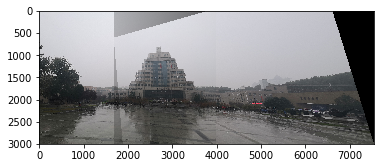

(<matplotlib.image.AxesImage at 0x11d39901128>, None)

In [9]:
    rows, cols = warpImg.shape[:2]
    # find boundary of warpImg
    for col in range(0, cols):
        if warpImg[:, col].any():
            left = col
            break
    for col in range(cols-1, 0, -1):
        if warpImg[:, col].any():
            right = col
            break
    # stitch
    output = np.zeros([rows, right, 3], np.uint8)
    for col in range(0, right):
        if not img1[:, col].any():
            output[:, col] = warpImg[:, col]
        elif not warpImg[:, col].any():
            output[:, col] = img1[:, col]
        else:
            img1_len = float(col)
            warpImg_len = float(abs(col - right))
            alpha = img1_len / (img1_len + warpImg_len)
            output[:, col] = np.clip(img1[:, col] * (1-alpha) + warpImg[:, col] * alpha, 0, 255)
    # draw
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(output), plt.show()